In [1]:
import pandas as pd
import numpy as np
import torch
import string
import emoji
import spacy
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from spacy.matcher import Matcher
from spacy.lang.en import English
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from collections import defaultdict
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
import matplotlib.pyplot as plt
from nltk.stem import PorterStemmer
# Load the English language model
nlp = spacy.load("en_core_web_sm")
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Input, Concatenate, Dense
from tensorflow.keras.models import Model

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
data = pd.read_csv(r'C:\Users\Dell\Downloads\archive (3)\train.csv')


In [3]:
data.shape

(2142, 6)

In [4]:
data.head()

,Unnamed: 0,description_x,description_y,ticker_x,ticker_y,same_security
0,0,first trust dow jones internet,first trust dj internet idx,FDN,FDN,True
1,1,schwab intl large company index etf,schwab strategic tr fundamental intl large co ...,FNDF,FNDF,True
2,2,vanguard small cap index adm,vanguard small-cap index fund inst,VSMAX,VSCIX,False
3,3,duke energy corp new com new isin #us4 sedol #...,duke energy corp new com new isin #us26441c204...,DUK,DUK,True
4,4,visa inc class a,visa inc.,V,V,True


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2142 entries, 0 to 2141
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Unnamed: 0     2142 non-null   int64 
 1   description_x  2142 non-null   object
 2   description_y  2142 non-null   object
 3   ticker_x       2142 non-null   object
 4   ticker_y       2142 non-null   object
 5   same_security  2142 non-null   bool  
dtypes: bool(1), int64(1), object(4)
memory usage: 85.9+ KB


In [6]:
print(data.describe())
data.isnull().sum()


        Unnamed: 0
count  2142.000000
mean   1070.500000
std     618.486459
min       0.000000
25%     535.250000
50%    1070.500000
75%    1605.750000
max    2141.000000


Unnamed: 0       0
description_x    0
description_y    0
ticker_x         0
ticker_y         0
same_security    0
dtype: int64

same_security
True     1613
False     529
Name: count, dtype: int64
same_security
True     75.303455
False    24.696545
Name: count, dtype: float64


<Axes: xlabel='same_security'>

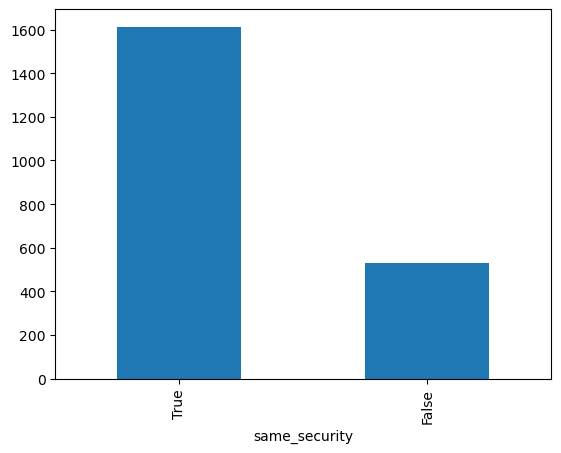

In [7]:
print(data['same_security'].value_counts())
print((data['same_security'].value_counts()/data['same_security'].count())*100)
data['same_security'].value_counts().plot(kind='bar')

In [8]:
data.duplicated().sum()

0

In [9]:
# Repeated Questions
qid=pd.Series(data['description_x'].tolist()+data['description_y'].tolist())
print('Number of unique questions',np.unique(qid).shape[0])
x=qid.value_counts()>1
print('Number of questions getting repeated',x[x].shape[0])

Number of unique questions 2597
Number of questions getting repeated 901


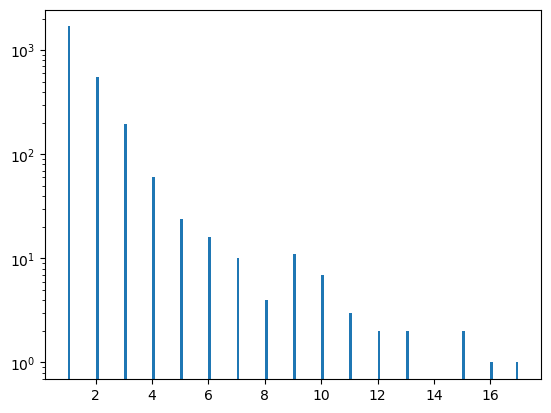

In [99]:
plt.hist(qid.value_counts().values,bins=160)
plt.yscale('log')
plt.show()

In [11]:
data.rename(columns ={'description_x':'question1','description_y':'question2','same_security':'is_similar'},inplace=True)
data.drop(columns=['ticker_x', 'ticker_y', data.columns[0]], inplace=True)


In [12]:
X_train, y_train = data[['question1', 'question2']], data['is_similar']

X_train, X_val_test, y_train, y_val_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")


X_train shape: (1713, 2), y_train shape: (1713,)
X_test shape: (215, 2), y_test shape: (215,)
X_val shape: (214, 2), y_val shape: (214,)


In [13]:
X_train.head()

,question1,question2
905,novo nordisk a s adr,novo nordisk a/s-adr nvorepstg 1/2 cl b sh
1699,spdr barclays high yieldbond etf,spdr barclays high yield bond (jnk)
1954,freeport mcmoran copper and gold inc,freeport-mcmoran inc
305,ishares msci switzerland capped,ishares msci switzerland capped etf
986,philip morris international inc,philip morris intl com


In [14]:
X_test.head()


,question1,question2
617,ld abt sh drtn inc i,lord abbett short duration income fd cl f
1978,trp retirement 2050,t. rowe price 2050 fund
554,wp carey inc com,w p carey and co. llc.
940,pimco income fund cl d,pimco incm cl d
49,prudential jennison natural resources z,pru/j nat resrcs z


In [15]:
X_val.head()

,question1,question2
1288,blackrock total return fund cl a,blackrock glbl opp eq tr f growth & income fund
188,energy transfer partners lp ut ltd,cheniere energy partners lp com
1656,facebook inc.,facebook inc class a common stock
1657,vang tot bd mk is pl,vanguard total bond market index inv
1677,vanguard intl equity index fd inc ftse all-wor...,vanguard intl equity index


In [16]:
def get_entities(sent):
    ent1 = ""
    ent2 = ""

    prv_tok_dep = ""  # dependency tag of the previous token in the sentence
    prv_tok_text = ""  # the previous token in the sentence

    prefix = ""
    modifier = ""

    for tok in nlp(sent):
        # if the token is a punctuation mark, then move on to the next token
        if tok.dep_ != "punct":
            # check if the token is a compound word or not
            if tok.dep_ == "compound":
                prefix = tok.text
                # if the previous word was also a 'compound', then add the current word to it
                if prv_tok_dep == "compound":
                    prefix = prv_tok_text + " " + tok.text
            # check if the token is a modifier or not
            if tok.dep_.endswith("mod") == True:
                modifier = tok.text
                # if the previous word was also a 'compound', then add the current word to it
                if prv_tok_dep == "compound":
                    modifier = prv_tok_text + " " + tok.text
            # check if the token is a subject
            if tok.dep_.find("subj") == True:
                ent1 = modifier + " " + prefix + " " + tok.text
                prefix = ""
                modifier = ""
                prv_tok_dep = ""
                prv_tok_text = ""
            # check if the token is an object
            if tok.dep_.find("obj") == True:
                ent2 = modifier + " " + prefix + " " + tok.text
            # update variables
            prv_tok_dep = tok.dep_
            prv_tok_text = tok.text

    return [ent1.strip(), ent2.strip()]

In [17]:
def clean_text(x):
    text = re.sub('(\d+)','',x)
    text = text.lower()
    return text
def remove_punct(x):
    text_without_puct = [t for t in x if t not in string.punctuation]
    text_without_puct = ''.join(text_without_puct)
    return text_without_puct
stemm = PorterStemmer()
def stemmer(x):
    tokens = word_tokenize(x)
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(token) for token in tokens]
    preprocessed_text = ' '.join(tokens)

    return preprocessed_text

In [18]:
def get_relation(sent):
    doc = nlp(sent)

    # Matcher class object
    matcher = Matcher(nlp.vocab)

    # Define the pattern
    pattern = [{'DEP': 'ROOT'},
               {'DEP': 'prep', 'OP': "?"},
               {'DEP': 'agent', 'OP': "?"},
               {'POS': 'ADJ', 'OP': "?"}]

    # Wrap the pattern in a list when adding to the Matcher
    matcher.add("matching_1", [pattern])

    matches = matcher(doc)
    k = len(matches) - 1

    span = doc[matches[k][1]:matches[k][2]]

    return span.text

In [19]:

X_train['question1'] = X_train['question1'].apply(clean_text)
X_train['question1'] = X_train['question1'].apply(remove_punct)
X_train['question1'] = X_train['question1'].apply(stemmer)

X_train['question2'] = X_train['question2'].apply(clean_text)
X_train['question2'] = X_train['question2'].apply(remove_punct)
X_train['question2'] = X_train['question2'].apply(stemmer)

X_test['question1'] = X_test['question1'].apply(clean_text)
X_test['question1'] = X_test['question1'].apply(remove_punct)
X_test['question1'] = X_test['question1'].apply(stemmer)


X_test['question2'] = X_test['question2'].apply(clean_text)
X_test['question2'] = X_test['question2'].apply(remove_punct)
X_test['question2'] = X_test['question2'].apply(stemmer)


X_val['question1'] = X_val['question1'].apply(clean_text)
X_val['question1'] = X_val['question1'].apply(remove_punct)
X_val['question1'] = X_val['question1'].apply(stemmer)


X_val['question2'] = X_val['question2'].apply(clean_text)
X_val['question2'] = X_val['question2'].apply(remove_punct)
X_val['question2'] = X_val['question2'].apply(stemmer)




In [20]:
entity_pairs_q1 = []
for i in tqdm(X_train["question1"]):
    entity_pairs_q1.append(get_entities(i))
relations_q1 = [get_relation(i) for i in tqdm(X_train['question1'])]


entity_pairs_q2 = []
for i in tqdm(X_train["question2"]):
    entity_pairs_q2.append(get_entities(i))
relations_q2 = [get_relation(i) for i in tqdm(X_train['question2'])]


entity_pairs_q1 = []
for i in tqdm(X_test["question1"]):
    entity_pairs_q1.append(get_entities(i))
relations_q1 = [get_relation(i) for i in tqdm(X_test['question1'])]


entity_pairs_q2 = []
for i in tqdm(X_test["question2"]):
    entity_pairs_q2.append(get_entities(i))
relations_q2 = [get_relation(i) for i in tqdm(X_test['question2'])]



entity_pairs_q1 = []
for i in tqdm(X_val["question1"]):
    entity_pairs_q1.append(get_entities(i))
relations_q1 = [get_relation(i) for i in tqdm(X_val['question1'])]


entity_pairs_q2 = []
for i in tqdm(X_val["question2"]):
    entity_pairs_q2.append(get_entities(i))
relations_q2 = [get_relation(i) for i in tqdm(X_val['question2'])]

100%|██████████| 214/214 [00:02<00:00, 75.41it/s]


In [21]:
# Collect all tokens in a single list
all_tokens = X_train['question1'].tolist() + X_train['question2'].tolist()
all_tokens = X_test['question1'].tolist() + X_test['question2'].tolist()
all_tokens = X_val['question1'].tolist() + X_val['question2'].tolist()

In [22]:
# Build vocabulary and convert words to indices
word_to_idx = defaultdict(lambda: len(word_to_idx))
data_indices = []
for tokens in X_train['question1']:
    indices = [word_to_idx[token] for token in tokens]
    data_indices.append(indices)
vocab_size = len(word_to_idx)


# Build vocabulary and convert words to indices
word_to_idx = defaultdict(lambda: len(word_to_idx))
data_indices = []
for tokens in X_test['question1']:
    indices = [word_to_idx[token] for token in tokens]
    data_indices.append(indices)
vocab_size = len(word_to_idx)

# Build vocabulary and convert words to indices
word_to_idx = defaultdict(lambda: len(word_to_idx))
data_indices = []
for tokens in X_val['question1']:
    indices = [word_to_idx[token] for token in tokens]
    data_indices.append(indices)
vocab_size = len(word_to_idx)

In [23]:
# Set Word2Vec parameters
embed_dim = 100
window_size = 5
learning_rate = 0.01
epochs = 10
vocab_size = len(word_to_idx)


In [24]:
# Initialize word embeddings randomly (with fixed seed for consistency)
np.random.seed(42)
word_embeddings = np.random.randn(vocab_size, embed_dim)

In [25]:
# Train Word2Vec model
for _ in range(epochs):
    for tokens in data_indices:
        for target_idx, target_word in enumerate(tokens):
            context_words = tokens[max(0, target_idx - window_size):target_idx] + \
                            tokens[target_idx + 1:min(target_idx + window_size + 1, len(tokens))]
            for context_word in context_words:
                target_idx_word = word_to_idx[target_word]
                context_idx_word = word_to_idx[context_word]
                if target_idx_word >= vocab_size or context_idx_word >= vocab_size:
                    continue  # Skip if index is out of bounds
                target_embed = word_embeddings[target_idx_word]
                context_embed = word_embeddings[context_idx_word]
                dot_product = np.dot(target_embed, context_embed)

In [26]:
# Save the trained Word2Vec model
np.save('word_embeddings.npy', word_embeddings)
word_embeddings = np.load('word_embeddings.npy')

In [27]:
# تعريف دالة لحساب تضمين الجملة
def sentence_embedding(tokens):
    embeddings = [word_embeddings[word_to_idx[token]] for token in tokens if token in word_to_idx]
    if embeddings:
        embedding = np.mean(embeddings, axis=0)
    else:
        embedding = np.zeros(word_embeddings.shape[1])  # Return zeros if no valid embeddings found
    return embedding

X_train['question1_embedding'] = X_train['question1'].apply(sentence_embedding)
X_train['question2_embedding'] = X_train['question2'].apply(sentence_embedding)

X_train['question1_embedding']
X_train['question2_embedding']

905     [0.1510997008792348, 0.17089837379908235, 0.02...
1699    [-0.11648744061788212, 0.1266175660105227, -0....
1954    [0.4625978591800741, -0.20425922480059427, 0.3...
305     [0.17725748937794775, 0.2528124066385635, -0.0...
986     [0.21721887840511928, -0.06711562830640486, -0...
                              ...                        
1638    [0.3475490213317623, 0.04845126722199611, 0.21...
1095    [0.17655521014135322, 0.04088006056024692, 0.1...
1130    [0.08715739223387636, 0.1839912319526426, 0.19...
1294    [0.05885926849232315, 0.11879526923331765, -0....
860     [-0.10401900321714036, -0.18364288017271044, 0...
Name: question2_embedding, Length: 1713, dtype: object

In [28]:
# تعريف دالة لحساب تضمين الجملة
def sentence_embedding(tokens):
    embeddings = [word_embeddings[word_to_idx[token]] for token in tokens if token in word_to_idx]
    if embeddings:
        embedding = np.mean(embeddings, axis=0)
    else:
        embedding = np.zeros(word_embeddings.shape[1])  # Return zeros if no valid embeddings found
    return embedding

X_test['question1_embedding'] = X_test['question1'].apply(sentence_embedding)
X_test['question2_embedding'] = X_test['question2'].apply(sentence_embedding)

X_test['question1_embedding']
X_test['question2_embedding']

617     [0.10666870485125012, 0.20386688879160839, -0....
1978    [0.3941859771722372, 0.18201523679711126, -0.0...
554     [-0.0813540971357979, 0.0917351801106609, 0.12...
940     [-0.07215703352556586, -0.20409082671345427, 0...
49      [0.20657953381905914, 0.5904272190663447, -0.1...
                              ...                        
1999    [0.42070800943460473, -0.0741185291245811, 0.2...
409     [-0.021816252409610295, 0.03487264574789953, -...
610     [0.5275533926931878, -0.21267736591573633, 0.0...
1380    [0.3365214021436171, 0.3863823254830411, 0.093...
2114    [0.2753429346086572, 0.2901652063984354, 0.033...
Name: question2_embedding, Length: 215, dtype: object

In [29]:
# تعريف دالة لحساب تضمين الجملة
def sentence_embedding(tokens):
    embeddings = [word_embeddings[word_to_idx[token]] for token in tokens if token in word_to_idx]
    if embeddings:
        embedding = np.mean(embeddings, axis=0)
    else:
        embedding = np.zeros(word_embeddings.shape[1])  # Return zeros if no valid embeddings found
    return embedding

X_val['question1_embedding'] = X_val['question1'].apply(sentence_embedding)
X_val['question2_embedding'] = X_val['question2'].apply(sentence_embedding)

X_val['question1_embedding']
X_val['question2_embedding']

1288    [-0.028019837295289615, 0.03233382078721756, 0...
188     [0.2281793869117545, -0.033949403366445606, 0....
1656    [-0.02897013637794444, -0.19598445636003875, 0...
1657    [0.3332128178292566, -0.10104393672443691, 0.1...
1677    [0.36144777879400347, -0.14200516363440546, 0....
                              ...                        
2118    [0.2330802275389303, -0.26177758367699455, 0.0...
973     [0.24386459838863267, 0.25917381920274, -0.029...
1607    [0.39112359435191374, -0.15792584986511846, 0....
2069    [0.16275338620103819, 0.12785366649832297, -0....
1177    [0.44722203441568686, 0.00364385227032315, 0.0...
Name: question2_embedding, Length: 214, dtype: object

In [30]:
X_train['similarity_score'] = X_train.apply(lambda row: cosine_similarity([row['question1_embedding']], [row['question2_embedding']])[0][0], axis=1)

print(X_train['similarity_score'])

905     0.957494
1699    0.958355
1954    0.917962
305     0.974752
986     0.908461
          ...   
1638    0.835898
1095    0.901078
1130    0.961082
1294    0.946506
860     0.963976
Name: similarity_score, Length: 1713, dtype: float64


In [31]:
X_test['similarity_score'] = X_test.apply(lambda row: cosine_similarity([row['question1_embedding']], [row['question2_embedding']])[0][0], axis=1)

print(X_test['similarity_score'])

617     0.819363
1978    0.649163
554     0.862549
940     0.945272
49      0.787175
          ...   
1999    0.869913
409     0.906821
610     0.893820
1380    0.908749
2114    0.976540
Name: similarity_score, Length: 215, dtype: float64


In [32]:
X_val['similarity_score'] = X_val.apply(lambda row: cosine_similarity([row['question1_embedding']], [row['question2_embedding']])[0][0], axis=1)

print(X_val['similarity_score'])

1288    0.882219
188     0.840005
1656    0.852874
1657    0.800685
1677    0.925080
          ...   
2118    0.976089
973     0.956304
1607    0.976213
2069    0.858958
1177    0.893975
Name: similarity_score, Length: 214, dtype: float64


In [33]:
X_train.head()

,question1,question2,question1_embedding,question2_embedding,similarity_score
905,novo nordisk a s adr,novo nordisk asadr nvorepstg cl b sh,"[0.20635870584842753, 0.20500242461882606, 0.0...","[0.1510997008792348, 0.17089837379908235, 0.02...",0.957494
1699,spdr barclay high yieldbond etf,spdr barclay high yield bond jnk,"[0.022589573974845376, 0.14644783096810238, -0...","[-0.11648744061788212, 0.1266175660105227, -0....",0.958355
1954,freeport mcmoran copper and gold inc,freeportmcmoran inc,"[0.19269153771819514, 0.004713147473101654, 0....","[0.4625978591800741, -0.20425922480059427, 0.3...",0.917962
305,ishar msci switzerland cap,ishar msci switzerland cap etf,"[0.1695486955523333, 0.30285200211500013, -0.0...","[0.17725748937794775, 0.2528124066385635, -0.0...",0.974752
986,philip morri intern inc,philip morri intl com,"[0.37357636172575287, -0.1982789870568978, -0....","[0.21721887840511928, -0.06711562830640486, -0...",0.908461


In [34]:
X_test.head()

,question1,question2,question1_embedding,question2_embedding,similarity_score
617,ld abt sh drtn inc i,lord abbett short durat incom fd cl f,"[0.005559664379992879, 0.11024834883853671, -0...","[0.10666870485125012, 0.20386688879160839, -0....",0.819363
1978,trp retir,t row price fund,"[0.6255601909267754, 0.5877591435893669, -0.54...","[0.3941859771722372, 0.18201523679711126, -0.0...",0.649163
554,wp carey inc com,w p carey and co llc,"[0.2521702597746931, -0.11624101786994645, 0.2...","[-0.0813540971357979, 0.0917351801106609, 0.12...",0.862549
940,pimco incom fund cl d,pimco incm cl d,"[0.04792427089015887, -0.20683349456724767, 0....","[-0.07215703352556586, -0.20409082671345427, 0...",0.945272
49,prudenti jennison natur resourc z,pruj nat resrc z,"[0.4362067059189712, 0.023848532097563956, 0.0...","[0.20657953381905914, 0.5904272190663447, -0.1...",0.787175


In [35]:
X_val.head()

,question1,question2,question1_embedding,question2_embedding,similarity_score
1288,blackrock total return fund cl a,blackrock glbl opp eq tr f growth incom fund,"[0.023825259360543135, 0.03780456144526624, 0....","[-0.028019837295289615, 0.03233382078721756, 0...",0.882219
188,energi transfer partner lp ut ltd,chenier energi partner lp com,"[0.2797050908227616, 0.19915441360445904, -0.0...","[0.2281793869117545, -0.033949403366445606, 0....",0.840005
1656,facebook inc,facebook inc class a common stock,"[0.07196725358664724, -0.530226979053655, 0.47...","[-0.02897013637794444, -0.19598445636003875, 0...",0.852874
1657,vang tot bd mk is pl,vanguard total bond market index inv,"[0.03459463683253243, 0.11220642406583976, 0.0...","[0.3332128178292566, -0.10104393672443691, 0.1...",0.800685
1677,vanguard intl equiti index fd inc ftse allworl...,vanguard intl equiti index,"[0.19024561963962633, -0.06739095178195993, -0...","[0.36144777879400347, -0.14200516363440546, 0....",0.925080


In [36]:
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")


X_train shape: (1713, 5), y_train shape: (1713,)
X_test shape: (215, 5), y_test shape: (215,)
X_val shape: (214, 5), y_val shape: (214,)


In [37]:
threshold = 0.5


y_pred = (X_train['similarity_score'] >= threshold).astype(int)



In [38]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_train, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.7553998832457677


In [39]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_train, y_pred)
print("Confusion Matrix:")
print(cm)


Confusion Matrix:
[[   0  419]
 [   0 1294]]


In [40]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_train, y_pred)
recall = recall_score(y_train, y_pred)
f1 = f1_score(y_train, y_pred)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


Precision: 0.7553998832457677
Recall: 1.0
F1 Score: 0.8606584635849683


In [41]:
import tensorflow as tf

loss_fn = tf.keras.losses.BinaryCrossentropy()

In [42]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
batch_size = 32
epochs = 10


In [43]:
import numpy as np
from tensorflow.keras.layers import Input, Dense, Concatenate
from tensorflow.keras.models import Model

# Load your Word2Vec model
word2vec_model = np.load('word_embeddings.npy')

# Input layers for sentence embeddings
input1 = Input(shape=(word2vec_model.shape[1],))  # Assuming the shape is (num_words, vector_size)
input2 = Input(shape=(word2vec_model.shape[1],))

# Dense layers
dense1 = Dense(15, activation='relu')(input1)
dense2 = Dense(15, activation='relu')(input2)

# Concatenate and output
concat = Concatenate()([dense1, dense2])
output = Dense(1, activation='sigmoid')(concat)

# Define the model
model = Model(inputs=[input1, input2], outputs=output)


In [55]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Concatenate, Dense
from tensorflow.keras.models import Model

# Preprocess your data
X_train_X1 = np.array(X_train['question1_embedding'].tolist())
X_train_X2 = np.array(X_train['question2_embedding'].tolist())
X_train_y = X_train['similarity_score'].values

X_test_X1 = np.array(X_test['question1_embedding'].tolist())
X_test_X2 = np.array(X_test['question2_embedding'].tolist())
X_test_y = X_test['similarity_score'].values



# Define input shapes
input_dim = X_train_X1.shape[1]

input_shape = (input_dim,)  # Define your input dimension

# Define inputs
input1 = Input(shape=input_shape)
input2 = Input(shape=input_shape)

# Concatenate the inputs
concatenated = Concatenate(axis=-1)([input1, input2])

# Add dense layers for processing
dense1 = Dense(32, activation='relu')(concatenated)
dense2 = Dense(64, activation='relu')(dense1)

# Output layer
output = Dense(1, activation='sigmoid')(dense2)  # Output similarity score between 0 and 1

# Create the model
model = Model(inputs=[input1, input2], outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_9       │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 200)       │          0 │ input_layer_8[0]… │
│ (Concatenate)       │                   │            │ input_layer_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 32)        │      6,432 │ concatenate_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 64)        │      2,112 │ dense_12[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 1)         │         65 │ dense_13[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 8,609 (33.63 KB)

 Trainable params: 8,609 (33.63 KB)

 Non-trainable params: 0 (0.00 B)

In [58]:
# Assuming you have your training data X_train_X1, X_train_X2, and y_train ready

# Train the model
history = model.fit([X_train_X1, X_train_X2], y_train, batch_size=32, epochs=10, validation_split=0.15)

# After training, you can evaluate the model on test data
# Assuming you have your test data X_test_X1, X_test_X2, and y_test ready
test_loss, test_accuracy = model.evaluate([X_test_X1, X_test_X2], y_test)
print(f'Test Accuracy: {test_accuracy}')

Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7755 - loss: 0.4825 - val_accuracy: 0.8560 - val_loss: 0.3833
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8509 - loss: 0.3539 - val_accuracy: 0.8482 - val_loss: 0.3694
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8702 - loss: 0.3195 - val_accuracy: 0.8638 - val_loss: 0.3423
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8602 - loss: 0.3046 - val_accuracy: 0.8755 - val_loss: 0.3328
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8675 - loss: 0.2846 - val_accuracy: 0.8755 - val_loss: 0.3426
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8800 - loss: 0.2921 - val_accuracy: 0.8872 - val_loss: 0.3378
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8919 - loss: 0.2404 - val_accuracy: 0.8638 - val_loss: 0.3442
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9045 - loss: 0.2383 - val_accuracy: 0.8755 - val_loss

In [64]:
from sentence_transformers import SentenceTransformer, util
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
# Function to compute embeddings and cosine similarity scores
def compute_similarity_scores(model, question_pairs):
    embeddings1 = model.encode(question_pairs['question1'].tolist(), convert_to_tensor=True)
    embeddings2 = model.encode(question_pairs['question2'].tolist(), convert_to_tensor=True)
    cosine_scores = util.pytorch_cos_sim(embeddings1, embeddings2)
    return cosine_scores
# Compute similarity scores for the training set
train_scores = compute_similarity_scores(model, X_train)
print(f"Train similarity scores:\n{train_scores}")

# Compute similarity scores for the validation set
val_scores = compute_similarity_scores(model, X_val)
print(f"Validation similarity scores:\n{val_scores}")

# Compute similarity scores for the test set
test_scores = compute_similarity_scores(model, X_test)
print(f"Test similarity scores:\n{test_scores}")

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

C:\Users\Dell\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:148: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Dell\.cache\huggingface\hub\models--sentence-transformers--all-MiniLM-L6-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Train similarity scores:
tensor([[0.7018, 0.2973, 0.1653,  ..., 0.2056, 0.0700, 0.2535],
        [0.2019, 0.6900, 0.1422,  ..., 0.3246, 0.2457, 0.1732],
        [0.0416, 0.1317, 0.6836,  ..., 0.1339, 0.2495, 0.3050],
        ...,
        [0.1457, 0.2064, 0.2192,  ..., 0.8122, 0.2044, 0.0628],
        [0.1005, 0.1698, 0.3280,  ..., 0.1996, 0.9487, 0.2687],
        [0.2318, 0.1039, 0.3361,  ..., 0.0121, 0.2936, 0.9278]])
Validation similarity scores:
tensor([[0.7332, 0.1041, 0.3396,  ..., 0.2722, 0.4743, 0.2650],
        [0.1931, 0.7105, 0.0591,  ..., 0.1371, 0.2825, 0.1589],
        [0.3465, 0.2227, 0.6957,  ..., 0.2318, 0.1575, 0.2098],
        ...,
        [0.2865, 0.1340, 0.1673,  ..., 0.8443, 0.2782, 0.0595],
        [0.3804, 0.2179, 0.1466,  ..., 0.1237, 0.6755, 0.2934],
        [0.1976, 0.0712, 0.0762,  ..., 0.1004, 0.1356, 0.2642]])
Test similarity scores:
tensor([[0.4027, 0.0945, 0.3054,  ..., 0.2119, 0.2871, 0.1614],
        [0.2150, 0.2298, 0.2499,  ..., 0.2630, 0.2581, 0.1638

In [72]:
# Define a threshold for similarity scores

def convert_to_predictions(scores, threshold):
    predictions = []
    for score_list in scores:
        # Calculate the average similarity score for each pair
        avg_score = sum(score_list) / len(score_list)
        # Convert the average score to a binary prediction
        prediction = 1 if avg_score >= threshold else 0
        predictions.append(prediction)
    return predictions


from sklearn.metrics import precision_score, recall_score, f1_score

# Convert cosine_scores to binary predictions based on the chosen threshold
threshold = 0.5  # Adjust this threshold based on your validation set
binary_predictions = (train_scores.diag() > threshold).int()

# Calculate precision, recall, and F1 score
accuracy = accuracy_score(y_train, binary_predictions)
precision = precision_score(y_train, binary_predictions)
recall = recall_score(y_train, binary_predictions)
f1 = f1_score(y_train, binary_predictions)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")




Accuracy: 0.7904261529480444
Precision: 0.8157
Recall: 0.9335
F1 Score: 0.8706


In [75]:
# Define a threshold for similarity scores

def convert_to_predictions(scores, threshold):
    predictions = []
    for score_list in scores:
        # Calculate the average similarity score for each pair
        avg_score = sum(score_list) / len(score_list)
        # Convert the average score to a binary prediction
        prediction = 1 if avg_score >= threshold else 0
        predictions.append(prediction)
    return predictions


from sklearn.metrics import precision_score, recall_score, f1_score

# Convert cosine_scores to binary predictions based on the chosen threshold
threshold = 0.5  # Adjust this threshold based on your validation set
test_binary_predictions = (test_scores.diag() > threshold).int()

# Calculate precision, recall, and F1 score
accuracy = accuracy_score(y_test, test_binary_predictions)
precision = precision_score(y_test, test_binary_predictions)
recall = recall_score(y_test, test_binary_predictions)
f1 = f1_score(y_test, test_binary_predictions)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")




Accuracy: 0.7488372093023256
Precision: 0.7903
Recall: 0.9074
F1 Score: 0.8448


In [79]:
import numpy as np
import tkinter as tk
from tkinter import simpledialog

# Load your Word2Vec model
word_embeddings = np.load('word_embeddings.npy')

# Function to find the most similar words (dummy function for illustration)
def find_similar_words(word):
    # Your logic to find similar words goes here
    # For now, it just returns a dummy list
    return ["word1", "word2", "word3"]

# Create the main window
root = tk.Tk()
root.title("Word2Vec GUI")

# Add an entry field
entry = tk.Entry(root)
entry.pack()

# Function to handle button click
def on_button_click():
    word = entry.get()
    similar_words = find_similar_words(word)
    result_label.config(text="\n".join(similar_words))

# Add a button
button = tk.Button(root, text="Find Similar Words", command=on_button_click)
button.pack()

# Add a label to display results
result_label = tk.Label(root, text="")
result_label.pack()

# Run the application
root.mainloop()


In [97]:
import tkinter as tk
from tkinter import ttk
import numpy as np
from scipy.spatial.distance import cosine
from collections import defaultdict  # Import defaultdict to use in text_to_index

# Load the numpy array of word embeddings (replace 'word_embeddings.npy' with your file path)
word_embeddings = np.load('word_embeddings.npy')

# Dummy function to convert text to indices (you'll need to implement this)
def text_to_index(text):
    word_to_idx = defaultdict(lambda: len(word_to_idx))
    data_indices = []
    for tokens in X_train['question1']:
        indices = [word_to_idx[token] for token in tokens]
        data_indices.append(indices)
    vocab_size = len(word_to_idx)
    return hash(text) % len(word_embeddings)


# Function to calculate sentence similarity
def calculate_similarity():
    text1 = entry1.get()
    text2 = entry2.get()
    
    # Convert the input sentences into indices
    index1 = text_to_index(text1)
    index2 = text_to_index(text2)
    
    # Retrieve embeddings for the indices
    embedding1 = word_embeddings[index1]
    embedding2 = word_embeddings[index2]
    
    # Calculate cosine similarity between the vectors
    similarity_score = 1 - cosine(embedding1, embedding2)
    
    # Display the similarity score
    output_text.delete(1.0, tk.END)
    output_text.insert(tk.END, f"Similarity Score: {similarity_score:.4f}")

# Create the main window
root = tk.Tk()
root.title("Sentence Similarity Model GUI")

# Create input fields
label1 = ttk.Label(root, text="Input 1:")
label1.grid(row=0, column=0, padx=5, pady=5, sticky="w")
entry1 = ttk.Entry(root, width=40)
entry1.grid(row=0, column=1, padx=5, pady=5)

label2 = ttk.Label(root, text="Input 2:")
label2.grid(row=1, column=0, padx=5, pady=5, sticky="w")
entry2 = ttk.Entry(root, width=40)
entry2.grid(row=1, column=1, padx=5, pady=5)

# Create button to trigger similarity calculation
calculate_button = ttk.Button(root, text="Calculate Similarity", command=calculate_similarity)
calculate_button.grid(row=2, column=0, columnspan=2, padx=5, pady=5)

# Create output field
output_text = tk.Text(root, height=2, width=50)
output_text.grid(row=3, column=0, columnspan=2, padx=5, pady=5)

root.mainloop()
